In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle

In [2]:
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
# EXPERIMENT_DIR = '/data2/experiments/{}'.format(EXPERIMENT_NAME)
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)

In [3]:
FEATURES_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_DEDUP_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)

In [4]:
with open(FEATURES_3DID_DEDUP_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_dedup_df']

In [5]:
features_3did_df.columns

Index(['monoisotopic_mz', 'charge', 'monoisotopic_mass', 'feature_intensity',
       'envelope_mono_peak_intensity', 'envelope', 'isotope_count',
       'deconvolution_score', 'precursor_cuboid_id', 'scan_apex', 'scan_lower',
       'scan_upper', 'rt_apex', 'rt_lower', 'rt_upper',
       'envelope_mono_peak_three_sigma_intensity', 'feature_id'],
      dtype='object')

In [6]:
# load the PASEF de-duped features and constrain them to match the 3DID analysis parameters
FEATURES_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_DEDUP_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)

In [7]:
with open(FEATURES_PASEF_DEDUP_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_pasef_df = d['features_dedup_df']

In [23]:
features_pasef_df = features_pasef_df[(features_pasef_df.envelope_mono_peak_three_sigma_intensity > 0)].copy()
features_3did_df = features_3did_df[(features_3did_df.envelope_mono_peak_three_sigma_intensity > 0)].copy()

In [24]:
print('there are {} features from 3DID, {} from PASEF'.format(len(features_3did_df), len(features_pasef_df)))

there are 92333 features from 3DID, 65401 from PASEF


In [25]:
features_pasef_df['intensity_log'] = np.log10(features_pasef_df.envelope_mono_peak_three_sigma_intensity)
features_pasef_df['method'] = 'pasef'
features_3did_df['intensity_log'] = np.log10(features_3did_df.envelope_mono_peak_three_sigma_intensity)
features_3did_df['method'] = '3did'

In [26]:
intensities_l = [features_pasef_df,features_3did_df]
intensities_df = pd.concat(intensities_l, sort=False)

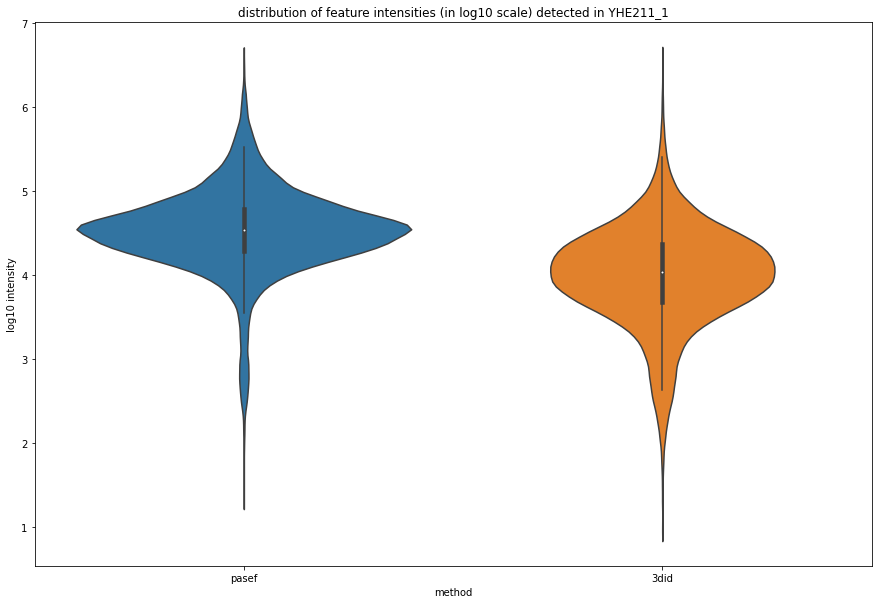

In [27]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1')

#### compare charge states

In [13]:
features_pasef_df.charge.max(), features_3did_df.charge.max()

(5, 5)

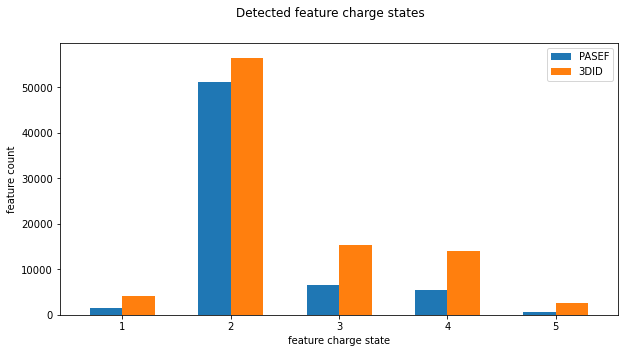

In [14]:
f, ax1 = plt.subplots()
f.set_figheight(5)
f.set_figwidth(10)
plt.hist([features_pasef_df.charge, features_3did_df.charge], bins=np.arange(start=1, stop=7)-0.5, rwidth=0.6, label=['PASEF','3DID'])
plt.legend(loc='best')
plt.xlabel('feature charge state')
plt.ylabel('feature count')
plt.margins(0.06)
plt.suptitle('Detected feature charge states')
# plt.title('{}'.format(feature_list_filename))
plt.show()

#### compare isotope counts

In [15]:
len(features_pasef_df[features_pasef_df.isotope_count==9]), len(features_3did_df[features_3did_df.isotope_count==9])

(29, 55)

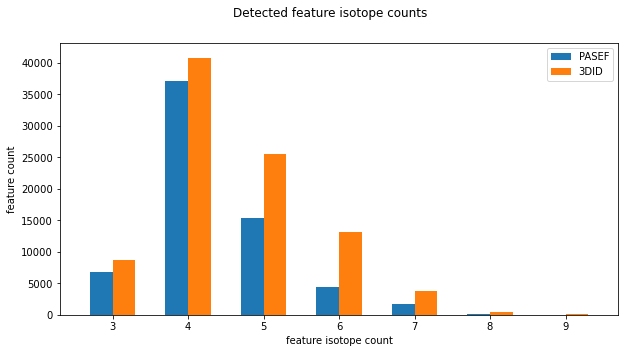

In [16]:
f, ax1 = plt.subplots()
f.set_figheight(5)
f.set_figwidth(10)
plt.hist([features_pasef_df.isotope_count, features_3did_df.isotope_count], bins=np.arange(start=3, stop=11)-0.5, rwidth=0.6, label=['PASEF','3DID'])
plt.legend(loc='best')
plt.xlabel('feature isotope count')
plt.ylabel('feature count')

plt.xticks(np.arange(3,10,1))

plt.margins(0.06)
plt.suptitle('Detected feature isotope counts')
# plt.title('{}'.format(feature_list_filename))
plt.show()

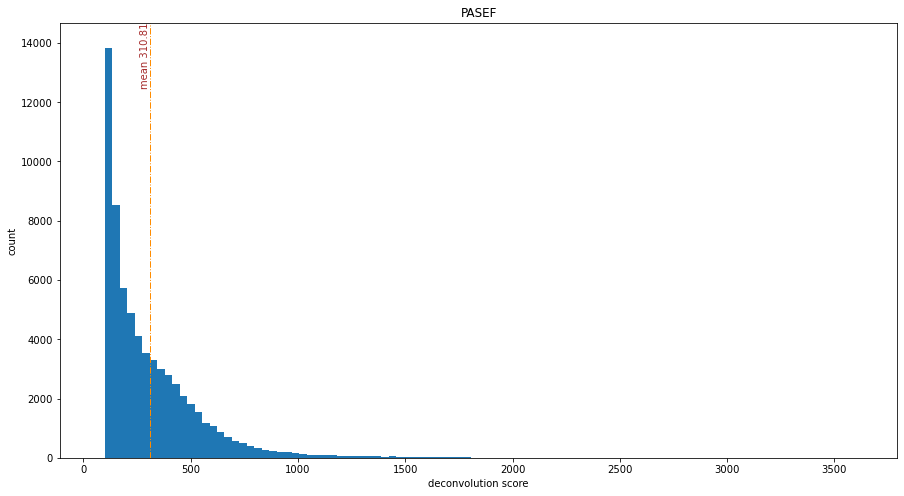

In [17]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
values = features_pasef_df.deconvolution_score
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('deconvolution score')
plt.ylabel('count')
plt.title('PASEF')
# plt.xlim((0,2))
# plt.ylim((0,1000))

plt.show()

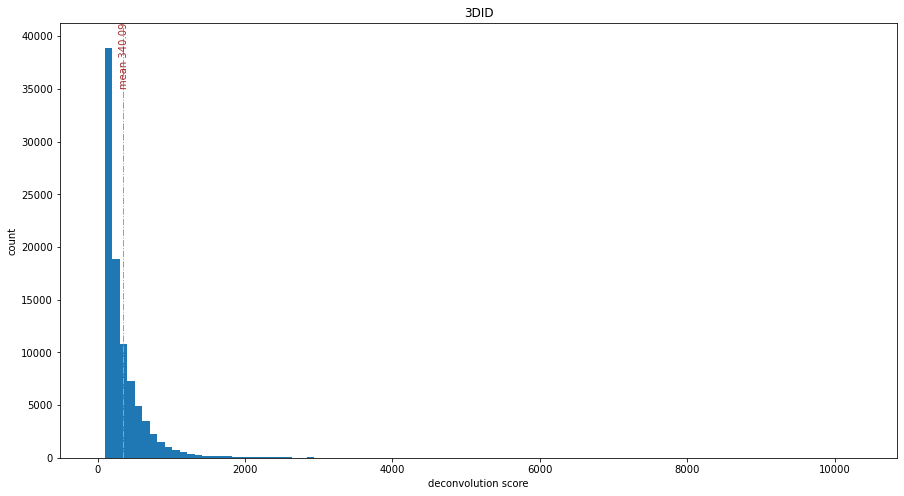

In [18]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
values = features_3did_df.deconvolution_score
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('deconvolution score')
plt.ylabel('count')
plt.title('3DID')
# plt.xlim((0,2))
# plt.ylim((0,1000))

plt.show()